# Regressão Logística I
## Tarefa II

Vamos trabalhar com a mesma base do exercício anterior, mas vamos aprofundar um pouco mais a nossa regressão.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.formula.api as smf

from sklearn.metrics import roc_curve
from sklearn import metrics
from scipy.stats import ks_2samp

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

df = pd.read_csv(url, 
                 names=['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                        'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'])
df['flag_doente'] = (df['num']!=0).astype('int64')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0


A descrição das variáveis está recortada abaixo:
- age: idade do paciente em anos
- sex: sexo (1 = male; 0 = female)  
- cp: tipo de dor no peito
  - 1: angina típica
  - 2: angina atípica
  - 3: dor não-angina
  - 4: assintomático
- trestbps: pressão sanguínea em repouso (em mm Hg na admissão ao hospital
- chol: colesterol sérico em mg/dl
- fbs: (açúcar no sangue em jejum > 120 mg/dl) (1 = True; 0 = False)
- restecg: resultados eletrocardiográficos em repouso
  - 0: normal
  - 1: tendo anormalidade da onda ST-T (Inversões de onda T e / ou ST com elevação ou depressão de > 0.05 mV)
  - 2: mostrando hipertrofia ventricular esquerda provável ou definitiva pelos critérios de Estes
- thalach: frequência cardíaca máxima alcançada
- exang: angina induzida por exercício(1 = sim; 0 = não)
- oldpeak = Depressão de ST induzida por exercício em relação ao repouso
- slope: Depressão de ST induzida por exercício em relação ao repouso
  - 1: inclinação ascendente
  - 2: estável
  - 3: inclinação descendente
- ca: número de vasos principais (0-3) coloridos por fluorosopia
- thal: 3 = normal; 6 = defeito corrigido; 7 = defeito reversível
- num: diagnóstico de doença cardíaga (status de doença angiográfica)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          303 non-null    float64
 1   sex          303 non-null    float64
 2   cp           303 non-null    float64
 3   trestbps     303 non-null    float64
 4   chol         303 non-null    float64
 5   fbs          303 non-null    float64
 6   restecg      303 non-null    float64
 7   thalach      303 non-null    float64
 8   exang        303 non-null    float64
 9   oldpeak      303 non-null    float64
 10  slope        303 non-null    float64
 11  ca           303 non-null    object 
 12  thal         303 non-null    object 
 13  num          303 non-null    int64  
 14  flag_doente  303 non-null    int64  
dtypes: float64(11), int64(2), object(2)
memory usage: 35.6+ KB


1. Considere o script que monta a análise bivariada que você fez na tarefa anterior. Transforme esse script em uma função, que deve:
- Ter como parâmetros de entrada:
    - Um *dataframe* contendo os dados a serem avaliados
    - Um *string* contendo o nome da variável resposta
    - Um *string* contendo o nome da variável explicativa
- E deve retornar um *dataframe* com os dados da bivariada. 
**Monte** a mesma bivariada pelo menos três variáveis qualitativas do *data-frame*. Qual delas parece discriminar mais o risco?

In [4]:
# Transformando o script em uma função
def analise_bivariada(df, resposta, explicativa):
    tab = pd.crosstab(df[explicativa], df[resposta], margins=True, margins_name='Total').rename(columns={0:'Saudáveis', 1:'Doentes'})

    tab['% Doentes'] = round(tab['Doentes'] / tab['Total'], 2)
    tab['Odds Doentes'] = round(tab['Doentes'] / tab['Saudáveis'], 2)
    tab['Odds Ratio'] = round(tab['Odds Doentes'] / tab.loc['Total', 'Odds Doentes'], 2)
    tab['Logito Doentes'] = round(np.log(tab['Odds Doentes']), 2)
    tab['(WOE)'] = round(np.log(tab['Odds Ratio']), 2)
    
    return tab

analise_bivariada(df, 'flag_doente', 'sex')

flag_doente,Saudáveis,Doentes,Total,% Doentes,Odds Doentes,Odds Ratio,Logito Doentes,(WOE)
sex,,,,,,,,
0.0,72,25,97,0.26,0.35,0.41,-1.05,-0.89
1.0,92,114,206,0.55,1.24,1.46,0.22,0.38
Total,164,139,303,0.46,0.85,1.00,-0.16,0.00


In [5]:
# Montando a bivariada para a variável 'cp' (tipo de dor no peito)
analise_bivariada(df, 'flag_doente', 'cp')

flag_doente,Saudáveis,Doentes,Total,% Doentes,Odds Doentes,Odds Ratio,Logito Doentes,(WOE)
cp,,,,,,,,
1.0,16,7,23,0.30,0.44,0.52,-0.82,-0.65
2.0,41,9,50,0.18,0.22,0.26,-1.51,-1.35
3.0,68,18,86,0.21,0.26,0.31,-1.35,-1.17
4.0,39,105,144,0.73,2.69,3.16,0.99,1.15
Total,164,139,303,0.46,0.85,1.00,-0.16,0.00


In [6]:
# Montando a bivariada para a variável 'restecg' (resultados eletrocardiográficos em repouso)
analise_bivariada(df, 'flag_doente', 'restecg')

flag_doente,Saudáveis,Doentes,Total,% Doentes,Odds Doentes,Odds Ratio,Logito Doentes,(WOE)
restecg,,,,,,,,
0.0,95,56,151,0.37,0.59,0.69,-0.53,-0.37
1.0,1,3,4,0.75,3.00,3.53,1.10,1.26
2.0,68,80,148,0.54,1.18,1.39,0.17,0.33
Total,164,139,303,0.46,0.85,1.00,-0.16,0.00


In [7]:
# Montando a bivariada para a variável 'thal' (resultado do exame de estresse)
analise_bivariada(df, 'flag_doente', 'thal')

flag_doente,Saudáveis,Doentes,Total,% Doentes,Odds Doentes,Odds Ratio,Logito Doentes,(WOE)
thal,,,,,,,,
3.0,129,37,166,0.22,0.29,0.34,-1.24,-1.08
6.0,6,12,18,0.67,2.00,2.35,0.69,0.85
7.0,28,89,117,0.76,3.18,3.74,1.16,1.32
?,1,1,2,0.50,1.00,1.18,0.00,0.17
Total,164,139,303,0.46,0.85,1.00,-0.16,0.00


<span style="color: darkolivegreen;">A variável 'thal' (resultado do exame de estresse) parece discriminar melhor o risco de doença cardíaca, com os valores 6.0 (defeito corrigido) e 7.0 (defeito reversível) apresentando as maiores porcentagens de doentes (67% e 76%, respectivamente). O odds ratio e o logito também são os maiores para esses valores, indicando uma associação mais forte com o risco de doença cardíaca.</span>

2. Monte uma função semelhante para categorizar variáveis quantitativas contínuas (com muitas categorias) como ```age```.  
    Além dos mesmos parâmetros da função anterior, defina mais um parâmetro como número de categorias que você deseja quebrar. Defina um valor '*default*' de 5 grupos para este parâmetro.  

In [8]:
def bivariada_quantitativa(df, resposta, explicativa, num_grupos=5):
    df['grupos'] = pd.qcut(df[explicativa], num_grupos, duplicates='drop')
    df['grupos'] = df['grupos'].apply(lambda age_group: f"{int(age_group.left)}-{int(age_group.right)}")

    tab = pd.crosstab(df['grupos'], df[resposta], margins=True, margins_name='Total').rename(columns={0:'Saudáveis', 1: 'Doentes'})
    
    tab['% Doentes'] = round(tab['Doentes'] / tab['Total'], 2)
    tab['Odds Doentes'] = round(tab['Doentes'] / tab['Saudáveis'], 2)
    tab['Odds Ratio'] = round(tab['Odds Doentes'] / tab.loc['Total', 'Odds Doentes'], 2)
    tab['Logito Doentes'] = round(np.log(tab['Odds Doentes']), 2)
    tab['(WOE)'] = round(np.log(tab['Odds Ratio']), 2)
    
    return tab

In [9]:
bivariada_quantitativa(df, 'flag_doente', 'age')

flag_doente,Saudáveis,Doentes,Total,% Doentes,Odds Doentes,Odds Ratio,Logito Doentes,(WOE)
grupos,,,,,,,,
28-45,47,16,63,0.25,0.34,0.40,-1.08,-0.92
45-53,42,22,64,0.34,0.52,0.61,-0.65,-0.49
53-58,32,39,71,0.55,1.22,1.44,0.20,0.36
58-62,13,32,45,0.71,2.46,2.89,0.90,1.06
62-77,30,30,60,0.50,1.00,1.18,0.00,0.17
Total,164,139,303,0.46,0.85,1.00,-0.16,0.00


3. Construa um modelo de regressão logística com as variáveis qualitativas: ```sex + cp +  trestbps``` e com a variável quantitativa ```age```.

**Interprete os parâmetros.**

In [10]:
reglog = smf.logit('flag_doente ~ C(sex) + C(cp, Treatment(4)) + trestbps + age'
                   , data=df).fit()
reglog.summary()

Optimization terminated successfully.
         Current function value: 0.476154
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      296
Method:                           MLE   Df Model:                            6
Date:                Fri, 28 Jul 2023   Pseudo R-squ.:                  0.3097
Time:                        20:52:03   Log-Likelihood:                -144.27
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 1.692e-25
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -5.8619      1.413     -4.147      0.000      -8.632      -3.092
C(sex)[T.1.0]                  1.8094      0.353      5.130      0.000       1.118       2.501
C(cp, Treatment(4))[T.1.0]    -2.4789      0.553     -4.485      0.000      -3.562      -1.396
C(cp, Treatment(4))[T.2.0]    -2.5406      0.452     -5.622      0.000      -3.426      -1.655
C(cp, Treatment(4))[T.3.0]    -2.4074      0.360     -6.690      0.000      -3.113      -1.702
trestbps                       0.0193      0.009      2.261      0.024       0.003       0.036
age                            0.0567      0.018      3.120      0.002       0.021       0.092
==============================================================================================
"""

<span style="color:darkolivegreen">O modelo de regressão logística mostra que as variáveis `sex`, `cp`, `trestbps` e `age` têm efeitos significativos na probabilidade de um paciente ser doente ou saudável.</span>

<span style="color:darkolivegreen">- `sex`: Pacientes do sexo masculino têm maior chance de serem doentes em comparação com pacientes do sexo feminino.</span>

<span style="color:darkolivegreen">- `cp`: Pacientes com angina típica, angina atípica e dor não-angina têm menor chance de serem doentes em comparação com pacientes assintomáticos.</span>

<span style="color:darkolivegreen">- `trestbps`: Um aumento na pressão sanguínea em repouso está associado a um aumento na chance de um paciente ser doente.</span>

<span style="color:darkolivegreen">- `age`: À medida que a idade do paciente aumenta, a chance de ser doente também aumenta.</span>


4. Avalie o seu modelo quanto a **calibragem**:
- Calcule a probabilidade de evento predita segundo o seu modelo
- Categorize essa probabilidade em G=5 grupos
- Calcule a probabilidade de evento predita média por grupo
- Calcule a taxa de eventos (média da variável indicadora de eventos) por grupo
- Compare graficamente o valor eperado versus observado para a taxa de maus por grupo

In [11]:
# Calculando a probabilidade de evento predita pelo modelo
df['predito'] = reglog.predict(df)

# Categorizando a probabilidade em 5 grupos
cat_pred = pd.qcut(df['predito'], q=5, duplicates='drop')
cat_pred.value_counts().sort_index()

(0.0131, 0.143]    62
(0.143, 0.287]     59
(0.287, 0.586]     62
(0.586, 0.822]     59
(0.822, 0.944]     61
Name: predito, dtype: int64

In [12]:
# Calculando a probabilidade de evento predita média por grupo
group_reg = df.groupby(cat_pred)
qualid = group_reg[['flag_doente']].count().rename(columns = {'flag_doente': 'contagem'})
qualid['predito'] = round(group_reg['predito'].mean(),2)
qualid

,contagem,predito
predito,,
"(0.0131, 0.143]",62,0.07
"(0.143, 0.287]",59,0.21
"(0.287, 0.586]",62,0.44
"(0.586, 0.822]",59,0.71
"(0.822, 0.944]",61,0.87


In [13]:
# Calculando a taxa de eventos por grupo
qualid['pct_sobrev'] = group_reg['flag_doente'].mean()
qualid

,contagem,predito,pct_sobrev
predito,,,
"(0.0131, 0.143]",62,0.07,0.080645
"(0.143, 0.287]",59,0.21,0.152542
"(0.287, 0.586]",62,0.44,0.483871
"(0.586, 0.822]",59,0.71,0.762712
"(0.822, 0.944]",61,0.87,0.819672


Text(0.5, 0, 'Grupo')

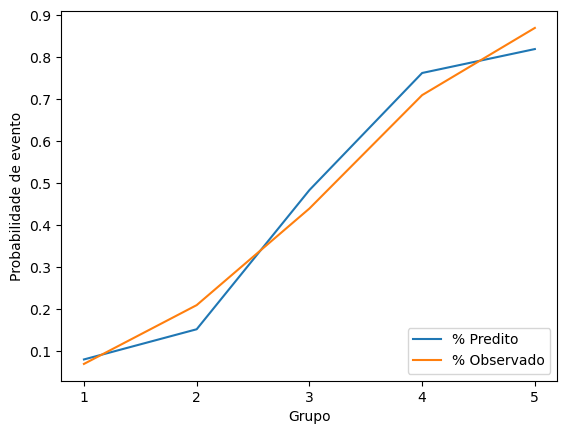

In [14]:
# Comparando graficamente o valor esperado versus observado para a taxa de maus por grupo
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax = qualid['pct_sobrev'].plot(label='% Predito')
ax = qualid['predito'].plot(label='% Observado')

ticks = ax.set_xticks([0, 1, 2, 3, 4])
labels = ax.set_xticklabels([1, 2, 3, 4, 5])
ax.legend(loc="lower right")
ax.set_ylabel('Probabilidade de evento')
ax.set_xlabel('Grupo')

5. Avalie o seu modelo quanto a discriminação calculando acurácia, GINI e KS.

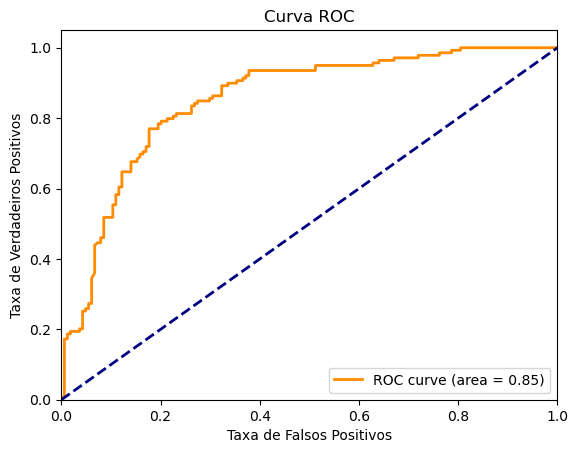

In [15]:
# Curva ROC
fpr, tpr, thresholds = metrics.roc_curve(df['flag_doente'], df['predito'])

plt.figure()
lw = 2

fpr, tpr, thresholds = metrics.roc_curve(df['flag_doente'], df['predito'])
auc_ = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

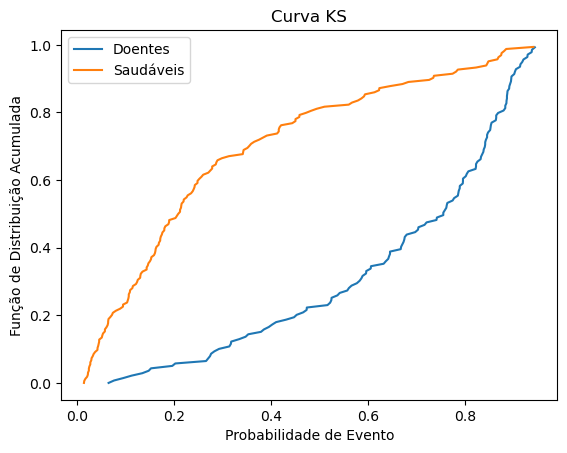

In [16]:
# Gráfico do KS
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

score_pop1 = df.loc[df['flag_doente']==1,'predito']
ax.plot(np.sort(score_pop1), np.linspace(0, 1, len(score_pop1), endpoint=False), label='Doentes')

score_pop2 = df.loc[df['flag_doente']!=1,'predito']
ax.plot(np.sort(score_pop2), np.linspace(0, 1, len(score_pop2), endpoint=False), label='Saudáveis')
ax.legend()

ax.set_xlabel('Probabilidade de Evento')
ax.set_ylabel('Função de Distribuição Acumulada')
plt.title('Curva KS');

In [17]:
acc = metrics.accuracy_score(df['flag_doente'], df['predito']>.5)
print('Acurácia: {0:.2f}%'.format(acc*100))

fpr, tpr, thresholds = metrics.roc_curve(df['flag_doente'], df['predito'])
auc_ = metrics.auc(fpr, tpr)

gini = 2*auc_ -1

ks = ks_2samp(df.loc[df['flag_doente'] == 1, 'predito'], df.loc[df['flag_doente'] != 1, 'predito']).statistic

print('KS: {0:.2f}% \nAUC: {1:.2f}% \nGINI: {2:.2f}%'
      .format(ks*100, auc_*100, gini*100))

Acurácia: 79.54%
KS: 59.30% 
AUC: 85.19% 
GINI: 70.39%


<span style="color:darkolivegreen">O modelo parece estar bem ajustado e possui uma boa capacidade de discriminação e classificação dos casos.</span>

6. tente melhorar o modelo obtido, por exemplo inserindo ou removendo variáveis.  
    Avalie as características do seu modelo (calibragem e acurácia).

In [45]:
reglog2 = smf.logit(" flag_doente ~ C(sex) + C(cp, Treatment(4)) + trestbps + C(thal) + oldpeak + age"
                   , data=df).fit()
reglog2.summary()

Optimization terminated successfully.
         Current function value: 0.397822
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      292
Method:                           MLE   Df Model:                           10
Date:                Fri, 28 Jul 2023   Pseudo R-squ.:                  0.4232
Time:                        21:31:01   Log-Likelihood:                -120.54
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 1.030e-32
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -5.6938      1.587     -3.589      0.000      -8.803      -2.584
C(sex)[T.1.0]                  1.2148      0.414      2.931      0.003       0.402       2.027
C(cp, Treatment(4))[T.1.0]    -2.4922      0.604     -4.126      0.000      -3.676      -1.308
C(cp, Treatment(4))[T.2.0]    -1.6632      0.483     -3.444      0.001      -2.610      -0.717
C(cp, Treatment(4))[T.3.0]    -2.2694      0.413     -5.499      0.000      -3.078      -1.461
C(thal)[T.6.0]                 0.5787      0.687      0.842      0.400      -0.768       1.925
C(thal)[T.7.0]                 1.5580      0.358      4.355      0.000       0.857       2.259
C(thal)[T.?]                   1.6710      2.268      0.737      0.461      -2.775       6.117
trestbps                       0.0127      0.009      1.354      0.176      -0.006       0.031
oldpeak                        0.7242      0.178      4.072      0.000       0.376       1.073
age                            0.0487      0.019      2.503      0.012       0.011       0.087
==============================================================================================
"""

In [46]:
df['predito'] = reglog2.predict(df)

acc = metrics.accuracy_score(df['flag_doente'], df['predito']>.5)
print('Acurácia: {0:.2f}%'.format(acc*100))

fpr, tpr, thresholds = metrics.roc_curve(df['flag_doente'], df['predito'])
auc_ = metrics.auc(fpr, tpr)

gini = 2*auc_ -1

ks = ks_2samp(df.loc[df['flag_doente'] == 1, 'predito'], df.loc[df['flag_doente'] != 1, 'predito']).statistic

print('KS: {0:.2f}% \nAUC: {1:.2f}% \nGINI: {2:.2f}%'
      .format(ks*100, auc_*100, gini*100))

Acurácia: 81.85%
KS: 66.32% 
AUC: 89.94% 
GINI: 79.88%


<span style="color:darkolivegreen">O novo modelo com as variáveis `oldpeak` e `thal` ficou mais preciso e apresentou uma performance superior em todas as métricas avaliadas, indicando que essas variáveis são mais relevantes para a previsão da doença cardíaca.</span>